<a href="https://www.kaggle.com/code/adelinmil/pg-s03e23-quick-and-dirty-implementation?scriptVersionId=145538640" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np

# ploting
import matplotlib.pyplot as plt
import scikitplot as skplt

# CV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# metrics
from sklearn.metrics import roc_auc_score

# models
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')

# <center> [PG S03E23 | EDA](https://www.kaggle.com/code/adelinmil/pg-s03e23-eda)

In [2]:
tr = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv', 
                 usecols = lambda x : x != 'id', dtype = {'defects': int})
ts = pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')

test_ids = ts.pop('id')

In [3]:
xtr, ytr = tr.drop('defects', axis = 1), tr['defects']

In [4]:
lgbm = LGBMClassifier()

kf = StratifiedKFold(n_splits = 10)
scores = cross_val_score(lgbm,
                        xtr,
                        ytr,
                        scoring = 'roc_auc',
                        cv = kf,
                        n_jobs = -1)
print(f'{lgbm.__class__.__name__} auroc score: {scores.mean()}')

LGBMClassifier auroc score: 0.7912452914713126


In [5]:
cat = CatBoostClassifier(verbose = False)

scores = cross_val_score(cat,
                        xtr,
                        ytr,
                        scoring = 'roc_auc',
                        cv = kf,
                        n_jobs = -1)
print(f'{cat.__class__.__name__} auroc score: {scores.mean()}')

CatBoostClassifier auroc score: 0.7904974381547765


In [6]:
hist = HistGradientBoostingClassifier()

scores = cross_val_score(hist,
                        xtr,
                        ytr,
                        scoring = 'roc_auc',
                        cv = kf,
                        n_jobs = -1)
print(f'{hist.__class__.__name__} auroc score: {scores.mean()}')

HistGradientBoostingClassifier auroc score: 0.7913378678533382


In [7]:
eclf = VotingClassifier(
     estimators=[('lgbm', lgbm), ('cat', cat), ('hist', hist)],
     voting='soft')

scores = cross_val_score(eclf,
                        xtr,
                        ytr,
                        scoring = 'roc_auc',
                        cv = kf,
                        n_jobs = -1)
print(f'{eclf.__class__.__name__} auroc score: {scores.mean()}')

VotingClassifier auroc score: 0.7921917789995312


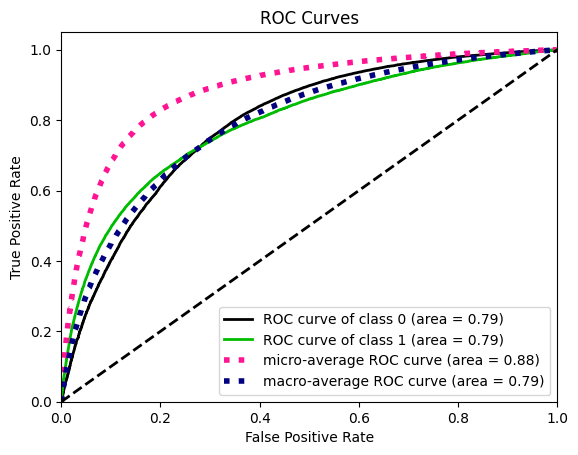

In [8]:
proba = cross_val_predict(eclf,
                          xtr,
                          ytr,
                          cv=kf,
                          method='predict_proba',
                          n_jobs = -1)

skplt.metrics.plot_roc_curve(ytr, proba)
plt.show()

In [9]:
eclf.fit(xtr, ytr)
submission = pd.DataFrame({'id': test_ids,
                          'defects': pd.Series(eclf.predict_proba(ts)[:, 1])})
submission.head()

,id,defects
0,101763,0.244858
1,101764,0.201762
2,101765,0.656055
3,101766,0.462706
4,101767,0.138767


In [10]:
submission.to_csv('submission.csv', index = False)

# <center> <span style="color:orange"> If You Find This Notebook Helpful Please Consider Upvoting and Sharing.